# Phase 3: XY Registration - Compare All MIP Methods

This notebook tests **4 different MIP projection methods** to find which gives the best registration results.

**⚠️ Phase 1 generates 4 MIP versions:**
1. **Original Max** - Maximum intensity projection
2. **Contrast-Enhanced** - Histogram equalization for better contrast
3. **Average Projection** - Mean instead of max (reduces noise)
4. **Vessel-Enhanced** - Frangi filter to enhance tubular structures

**This notebook will:**
- Test phase correlation registration on all 4 methods
- Compare confidence scores and alignment improvements
- Recommend the best method
- Save parameters for the winner

**⚠️ NOTE: Phase 2 (vessel segmentation) can be SKIPPED!**

## Setup and Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from scipy import signal, ndimage
import pandas as pd

# Setup paths (handle running from notebooks/ or root)
notebook_dir = Path.cwd()
if notebook_dir.name == 'notebooks':
    data_dir = notebook_dir / 'data'
else:
    data_dir = notebook_dir / 'notebooks' / 'data'

# Configure matplotlib
plt.rcParams['figure.figsize'] = (15, 10)

print("✓ Imports complete")

✓ Imports complete


## Load All 4 MIP Methods from Phase 1

In [2]:
# Load all 4 MIP versions for both volumes
print("=" * 70)
print("LOADING ALL MIP METHODS FROM PHASE 1")
print("=" * 70)

mip_methods = {
    'Original Max': {
        'v0': np.load(data_dir / 'enface_mip_original_volume0.npy'),
        'v1': np.load(data_dir / 'enface_mip_original_volume1.npy')
    },
    'Contrast-Enhanced': {
        'v0': np.load(data_dir / 'enface_mip_enhanced_volume0.npy'),
        'v1': np.load(data_dir / 'enface_mip_enhanced_volume1.npy')
    },
    'Average Projection': {
        'v0': np.load(data_dir / 'enface_mip_average_volume0.npy'),
        'v1': np.load(data_dir / 'enface_mip_average_volume1.npy')
    },
    'Vessel-Enhanced': {
        'v0': np.load(data_dir / 'enface_mip_vessels_volume0.npy'),
        'v1': np.load(data_dir / 'enface_mip_vessels_volume1.npy')
    }
}

# Display stats for each method
for method_name, mips in mip_methods.items():
    v0, v1 = mips['v0'], mips['v1']
    print(f"\n{method_name}:")
    print(f"  Shape: {v0.shape}")
    print(f"  Vol 0: mean={v0.mean():.1f}, std={v0.std():.1f}, range=[{v0.min()}, {v0.max()}]")
    print(f"  Vol 1: mean={v1.mean():.1f}, std={v1.std():.1f}, range=[{v1.min()}, {v1.max()}]")

print("\n" + "=" * 70)
print("✓ ALL MIP METHODS LOADED")
print("=" * 70)

LOADING ALL MIP METHODS FROM PHASE 1

Original Max:
  Shape: (1536, 360)
  Vol 0: mean=252.5, std=7.0, range=[171.0, 255.0]
  Vol 1: mean=244.2, std=13.7, range=[151.0, 255.0]

Contrast-Enhanced:
  Shape: (1536, 360)
  Vol 0: mean=230.9, std=56.4, range=[0, 255]
  Vol 1: mean=183.4, std=77.6, range=[0, 255]

Average Projection:
  Shape: (1536, 360)
  Vol 0: mean=122.7, std=24.0, range=[0, 255]
  Vol 1: mean=129.9, std=24.5, range=[0, 255]

Vessel-Enhanced:
  Shape: (1536, 360)
  Vol 0: mean=7.5, std=16.7, range=[0, 255]
  Vol 1: mean=5.3, std=13.0, range=[0, 255]

✓ ALL MIP METHODS LOADED


## Visualize All 4 MIP Methods

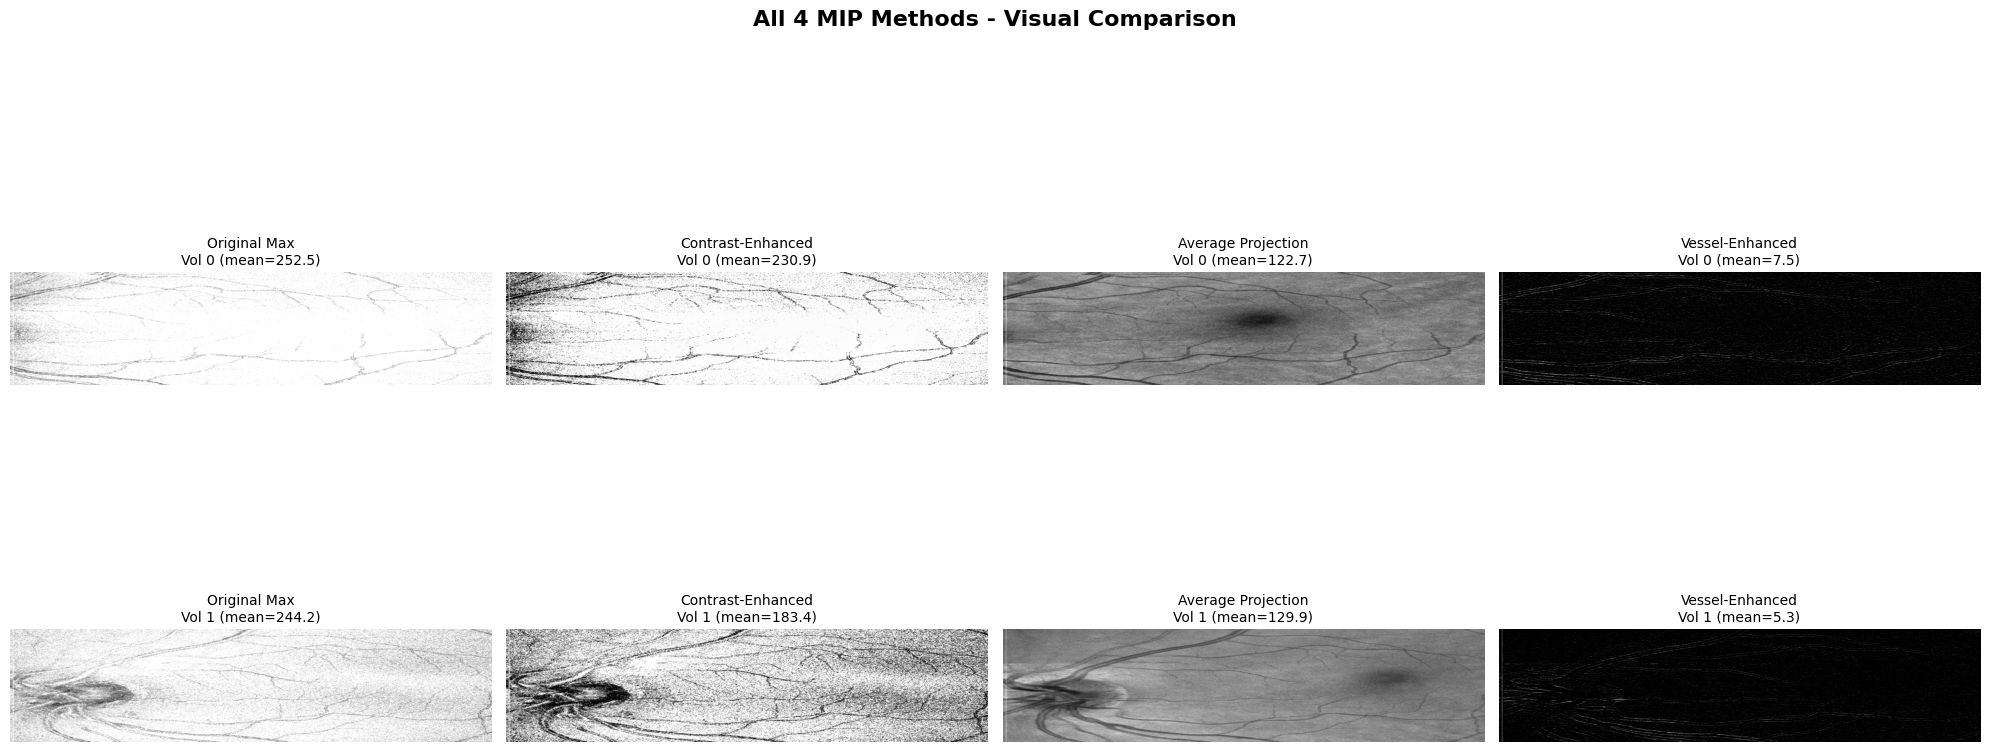


💡 Look for:
  - Best vessel contrast (darker vessels on lighter background)
  - Clear vessel patterns
  - Similar appearance between Vol 0 and Vol 1


In [3]:
# Visualize all methods side-by-side
fig, axes = plt.subplots(2, 4, figsize=(20, 10))

method_names = list(mip_methods.keys())

for i, method_name in enumerate(method_names):
    mips = mip_methods[method_name]
    
    # Volume 0
    axes[0, i].imshow(mips['v0'].T, cmap='gray', origin='lower')
    axes[0, i].set_title(f'{method_name}\nVol 0 (mean={mips["v0"].mean():.1f})', fontsize=10)
    axes[0, i].axis('off')
    
    # Volume 1
    axes[1, i].imshow(mips['v1'].T, cmap='gray', origin='lower')
    axes[1, i].set_title(f'{method_name}\nVol 1 (mean={mips["v1"].mean():.1f})', fontsize=10)
    axes[1, i].axis('off')

plt.suptitle('All 4 MIP Methods - Visual Comparison', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n💡 Look for:")
print("  - Best vessel contrast (darker vessels on lighter background)")
print("  - Clear vessel patterns")
print("  - Similar appearance between Vol 0 and Vol 1")

## Test Registration on All 4 Methods

In [4]:
def register_mip_phase_correlation(mip1, mip2):
    """
    Register two MIP en-face images using phase correlation.
    
    Args:
        mip1: Reference MIP from Volume 0
        mip2: MIP to align from Volume 1
    
    Returns:
        (dx, dz): Translation offset (lateral X, B-scan Z)
        confidence: Match quality score
        correlation: Full correlation map
    """
    # Normalize images (remove mean and scale by std)
    mip1_norm = (mip1 - mip1.mean()) / (mip1.std() + 1e-8)
    mip2_norm = (mip2 - mip2.mean()) / (mip2.std() + 1e-8)
    
    # Compute 2D correlation
    correlation = signal.correlate2d(mip1_norm, mip2_norm, mode='same')
    
    # Find peak (strongest match position)
    peak_x, peak_z = np.unravel_index(np.argmax(correlation), correlation.shape)
    center_x, center_z = np.array(correlation.shape) // 2
    
    # Calculate offset from center
    offset_x = peak_x - center_x
    offset_z = peak_z - center_z
    
    # Confidence = peak strength relative to noise
    confidence = correlation.max() / (correlation.std() + 1e-8)
    
    return (offset_x, offset_z), confidence, correlation

def test_registration_quality(mip1, mip2, offset):
    """Test alignment quality by applying offset and measuring improvement."""
    # Apply translation
    mip2_aligned = ndimage.shift(mip2, shift=offset, order=1, mode='constant', cval=0)
    
    # Calculate differences
    diff_before = np.abs(mip1.astype(float) - mip2.astype(float)).mean()
    diff_after = np.abs(mip1.astype(float) - mip2_aligned.astype(float)).mean()
    
    # Calculate improvement
    improvement = 100 * (1 - diff_after / diff_before)
    
    return mip2_aligned, diff_before, diff_after, improvement

print("✓ Registration functions defined")

✓ Registration functions defined


In [5]:
# Test registration on all 4 methods
print("=" * 70)
print("TESTING REGISTRATION ON ALL 4 MIP METHODS")
print("=" * 70)

results = {}

for method_name, mips in mip_methods.items():
    print(f"\n{method_name}:")
    print("  Running phase correlation...")
    
    # Register
    (offset_x, offset_z), confidence, corr_map = register_mip_phase_correlation(mips['v0'], mips['v1'])
    
    # Test quality
    aligned, diff_before, diff_after, improvement = test_registration_quality(
        mips['v0'], mips['v1'], (offset_x, offset_z)
    )
    
    # Store results
    results[method_name] = {
        'offset_x': offset_x,
        'offset_z': offset_z,
        'confidence': confidence,
        'diff_before': diff_before,
        'diff_after': diff_after,
        'improvement': improvement,
        'correlation_map': corr_map,
        'aligned': aligned
    }
    
    print(f"  Offset: ({offset_x}, {offset_z}) pixels")
    print(f"  Confidence: {confidence:.2f}")
    print(f"  Improvement: {improvement:.1f}%")

print("\n" + "=" * 70)
print("✓ ALL METHODS TESTED")
print("=" * 70)

TESTING REGISTRATION ON ALL 4 MIP METHODS

Original Max:
  Running phase correlation...
  Offset: (-69, 179) pixels
  Confidence: 3.71
  Improvement: -1145.3%

Contrast-Enhanced:
  Running phase correlation...
  Offset: (-69, 179) pixels
  Confidence: 3.09
  Improvement: -114.9%

Average Projection:
  Running phase correlation...
  Offset: (-413, 5) pixels
  Confidence: 5.12
  Improvement: -76.4%

Vessel-Enhanced:
  Running phase correlation...
  Offset: (-412, 5) pixels
  Confidence: 31.16
  Improvement: 15.8%

✓ ALL METHODS TESTED


## Compare Results - Find Best Method

In [6]:
# Create comparison table
print("=" * 90)
print("REGISTRATION COMPARISON TABLE")
print("=" * 90)

comparison_data = []
for method_name, res in results.items():
    comparison_data.append({
        'Method': method_name,
        'Offset X': res['offset_x'],
        'Offset Z': res['offset_z'],
        'Confidence': f"{res['confidence']:.2f}",
        'Diff Before': f"{res['diff_before']:.2f}",
        'Diff After': f"{res['diff_after']:.2f}",
        'Improvement %': f"{res['improvement']:.1f}"
    })

df = pd.DataFrame(comparison_data)
print(df.to_string(index=False))

# Find best method
best_method = None
best_score = -np.inf

for method_name, res in results.items():
    score = res['confidence'] if res['improvement'] > 0 else 0
    score += res['improvement'] / 100
    
    if score > best_score:
        best_score = score
        best_method = method_name

print("\n" + "=" * 90)
print(f"🏆 BEST METHOD: {best_method}")
print("=" * 90)
print(f"  Offset: ({results[best_method]['offset_x']}, {results[best_method]['offset_z']}) pixels")
print(f"  Confidence: {results[best_method]['confidence']:.2f}")
print(f"  Improvement: {results[best_method]['improvement']:.1f}%")
print("=" * 90)

REGISTRATION COMPARISON TABLE
            Method  Offset X  Offset Z Confidence Diff Before Diff After Improvement %
      Original Max       -69       179       3.71       10.99     136.91       -1145.3
 Contrast-Enhanced       -69       179       3.09       72.65     156.08        -114.9
Average Projection      -413         5       5.12       27.60      48.70         -76.4
   Vessel-Enhanced      -412         5      31.16       10.12       8.52          15.8

🏆 BEST METHOD: Vessel-Enhanced
  Offset: (-412, 5) pixels
  Confidence: 31.16
  Improvement: 15.8%


## Visualize Best Method

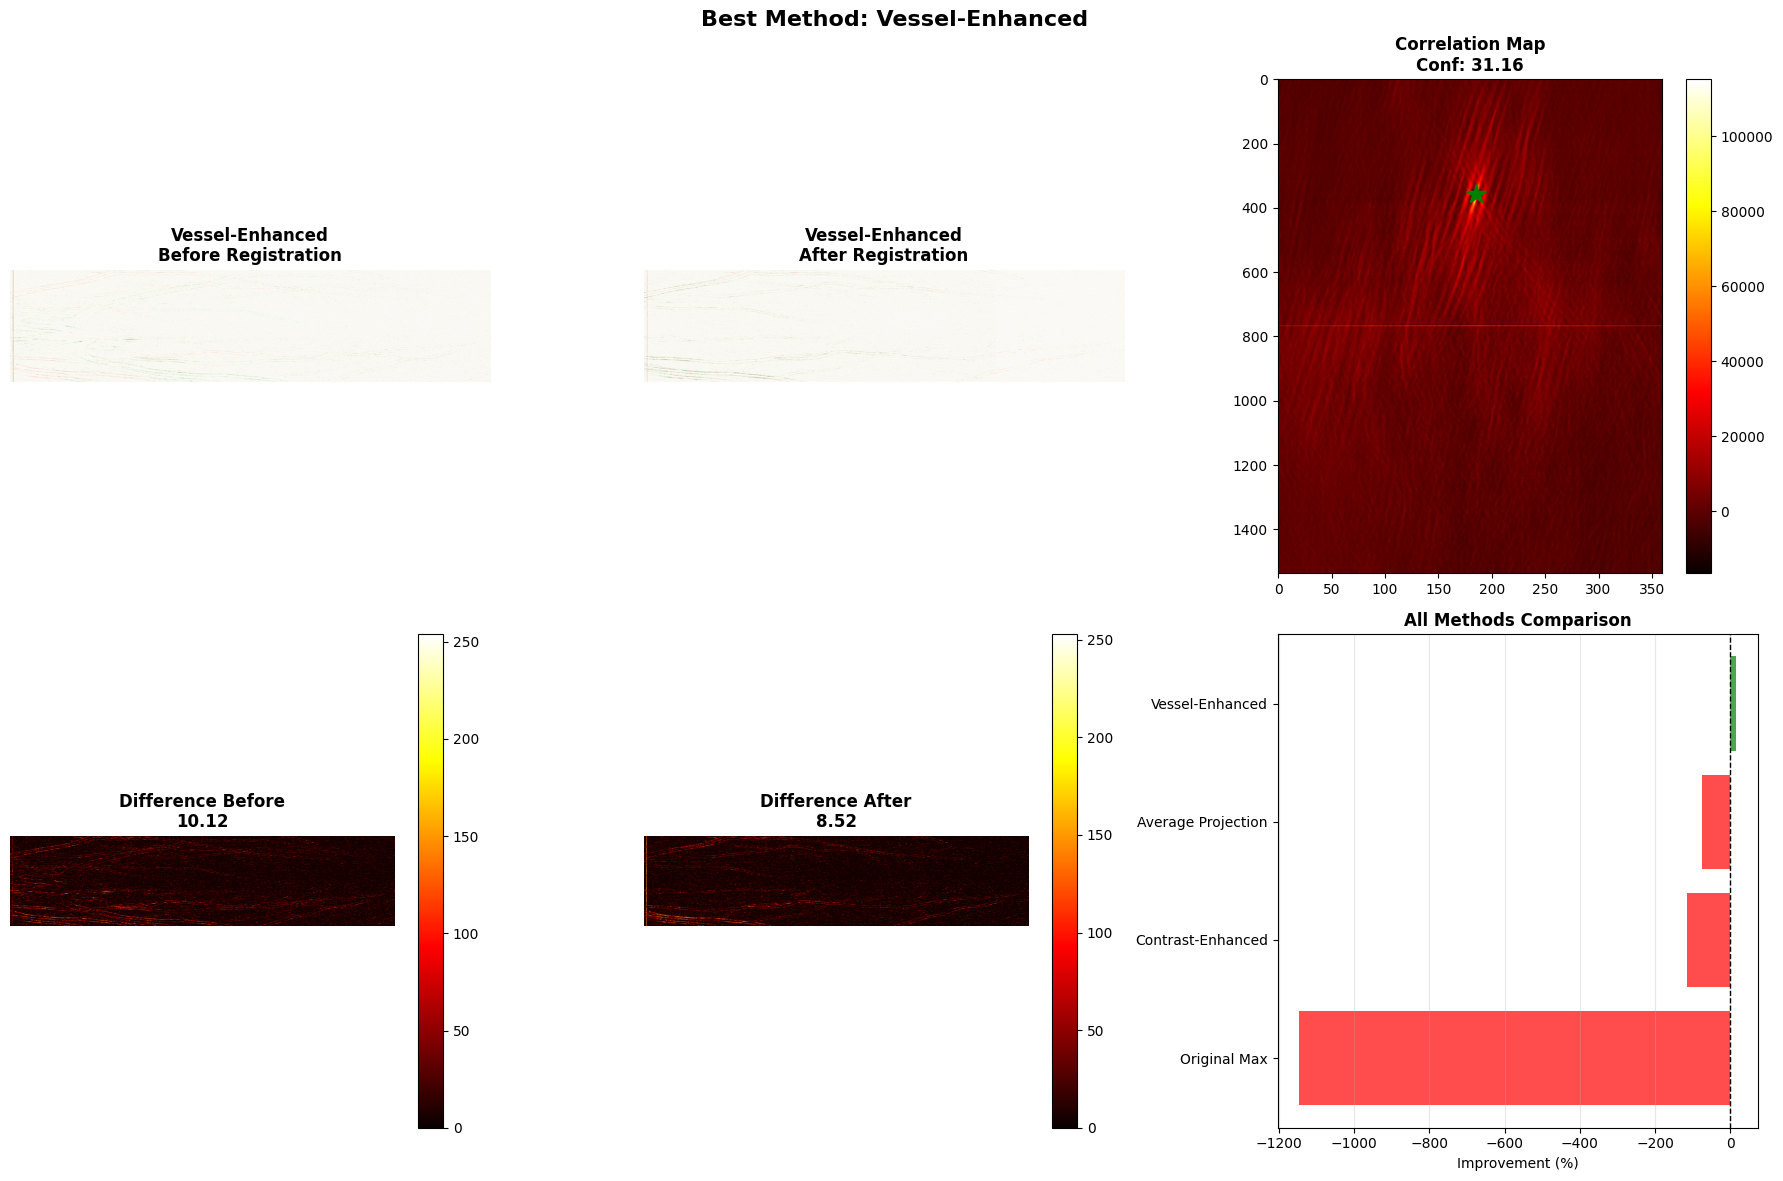

In [7]:
# Visualize the best method in detail
best_res = results[best_method]
best_mips = mip_methods[best_method]

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Before/After overlays
axes[0, 0].imshow(best_mips['v0'].T, cmap='Reds', alpha=0.5, origin='lower')
axes[0, 0].imshow(best_mips['v1'].T, cmap='Greens', alpha=0.5, origin='lower')
axes[0, 0].set_title(f'{best_method}\nBefore Registration', fontsize=12, fontweight='bold')
axes[0, 0].axis('off')

axes[0, 1].imshow(best_mips['v0'].T, cmap='Reds', alpha=0.5, origin='lower')
axes[0, 1].imshow(best_res['aligned'].T, cmap='Greens', alpha=0.5, origin='lower')
axes[0, 1].set_title(f'{best_method}\nAfter Registration', fontsize=12, fontweight='bold')
axes[0, 1].axis('off')

# Correlation map
peak_x, peak_z = np.unravel_index(np.argmax(best_res['correlation_map']), best_res['correlation_map'].shape)
im = axes[0, 2].imshow(best_res['correlation_map'], cmap='hot', aspect='auto')
axes[0, 2].plot(peak_z, peak_x, 'g*', markersize=15)
axes[0, 2].set_title(f'Correlation Map\nConf: {best_res["confidence"]:.2f}', fontsize=12, fontweight='bold')
plt.colorbar(im, ax=axes[0, 2])

# Difference maps
diff_before = np.abs(best_mips['v0'].astype(float) - best_mips['v1'].astype(float))
im1 = axes[1, 0].imshow(diff_before.T, cmap='hot', origin='lower')
axes[1, 0].set_title(f'Difference Before\n{diff_before.mean():.2f}', fontsize=12, fontweight='bold')
axes[1, 0].axis('off')
plt.colorbar(im1, ax=axes[1, 0])

diff_after = np.abs(best_mips['v0'].astype(float) - best_res['aligned'].astype(float))
im2 = axes[1, 1].imshow(diff_after.T, cmap='hot', origin='lower')
axes[1, 1].set_title(f'Difference After\n{diff_after.mean():.2f}', fontsize=12, fontweight='bold')
axes[1, 1].axis('off')
plt.colorbar(im2, ax=axes[1, 1])

# Improvement bar chart
method_names_list = list(results.keys())
improvements = [results[m]['improvement'] for m in method_names_list]
colors = ['green' if i > 0 else 'red' for i in improvements]
axes[1, 2].barh(method_names_list, improvements, color=colors, alpha=0.7)
axes[1, 2].axvline(0, color='black', linestyle='--', linewidth=1)
axes[1, 2].set_xlabel('Improvement (%)')
axes[1, 2].set_title('All Methods Comparison', fontsize=12, fontweight='bold')
axes[1, 2].grid(axis='x', alpha=0.3)

plt.suptitle(f'Best Method: {best_method}', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

## Save Best Method Results

In [8]:
# Save the best method's registration parameters
registration_params = {
    'best_method': best_method,
    'method': 'phase_correlation',
    'offset_x': int(best_res['offset_x']),
    'offset_z': int(best_res['offset_z']),
    'confidence': float(best_res['confidence']),
    'mean_diff_before': float(best_res['diff_before']),
    'mean_diff_after': float(best_res['diff_after']),
    'improvement_percent': float(best_res['improvement'])
}

# Save all method results
all_results = {}
for method_name, res in results.items():
    all_results[method_name] = {
        'offset_x': int(res['offset_x']),
        'offset_z': int(res['offset_z']),
        'confidence': float(res['confidence']),
        'improvement_percent': float(res['improvement'])
    }

# Save files
np.save(data_dir / 'xy_registration_params.npy', registration_params)
np.save(data_dir / 'xy_registration_all_methods.npy', all_results)
np.save(data_dir / 'mip_v1_xy_aligned.npy', best_res['aligned'])

print("=" * 70)
print("✓ SAVED REGISTRATION RESULTS")
print("=" * 70)
print(f"\nBest method: {best_method}")
print(f"  - xy_registration_params.npy")
print(f"  - xy_registration_all_methods.npy")
print(f"  - mip_v1_xy_aligned.npy")

print("\n" + "=" * 70)
print("✓ PHASE 3 COMPLETE!")
print("=" * 70)
print(f"\n🏆 Winner: {best_method}")
print(f"  Offset: ({best_res['offset_x']}, {best_res['offset_z']}) pixels")
print(f"  Confidence: {best_res['confidence']:.2f}")
print(f"  Improvement: {best_res['improvement']:.1f}%")

if best_res['confidence'] > 5.0 and best_res['improvement'] > 15:
    print("\n✅ EXCELLENT! Registration meets quality criteria!")
elif best_res['improvement'] > 0:
    print("\n⚠️  Registration improved but may need review")
else:
    print("\n❌ WARNING: Registration did not improve alignment")

print("\n➡️  Next: Phase 4 - Z-axis alignment")
print("=" * 70)

✓ SAVED REGISTRATION RESULTS

Best method: Vessel-Enhanced
  - xy_registration_params.npy
  - xy_registration_all_methods.npy
  - mip_v1_xy_aligned.npy

✓ PHASE 3 COMPLETE!

🏆 Winner: Vessel-Enhanced
  Offset: (-412, 5) pixels
  Confidence: 31.16
  Improvement: 15.8%

✅ EXCELLENT! Registration meets quality criteria!

➡️  Next: Phase 4 - Z-axis alignment
